In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import json
from environment import Environment
from logging_config import setup_logging
import logging
from utils import findUE, BPRCostFunction, findSO   
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "no-latex"])


In [54]:
import pandas as pd
import random
import numpy as np

In [55]:
params = None
with open("params.json") as f:
    params = json.load(f)
if not params:
    raise Exception("No parameters found!")
env1 = Environment(params) # area with PoA ~1.1
params['env_params']['PoA'] = 1.3
env2 = Environment(params) # area with PoA ~1.3
envs = [env1,env2]

Routes: [functools.partial(<function BPRCostFunction at 0x1127b5080>, t0=np.float64(1.0107362299251643), qmax=0.2783948686259838), functools.partial(<function BPRCostFunction at 0x1127b5080>, t0=np.float64(0.5405848768868518), qmax=0.1422126198350824), functools.partial(<function BPRCostFunction at 0x1127b5080>, t0=np.float64(1.2941478738540195), qmax=0.3793925115389339)]
Nash: [0.36751724 0.26174349 0.37073927]
SO: [0.34948459 0.22071538 0.42980002]
PoA: 1.1000000003833446
Routes: [functools.partial(<function BPRCostFunction at 0x1127b5080>, t0=np.float64(5.9470191753274105e-05), qmax=0.16649691314395126), functools.partial(<function BPRCostFunction at 0x1127b5080>, t0=np.float64(0.521801340884701), qmax=0.25618966800433834), functools.partial(<function BPRCostFunction at 0x1127b5080>, t0=np.float64(3.469539830498267), qmax=0.37731341885171044)]
Nash: [0.49181346 0.50818654 0.        ]
SO: [1.00000000e+00 5.27355937e-15 0.00000000e+00]
PoA: 1.300000217749993


[ENV 1], PoA=1.123, routes=3, Q_env=328, Inequities=-0.04, q_env=0.787, tUE=1.311, mean_SO_time=1.115, mean_inequity=-0.001, avg_inequity=0.000, tSO=[np.float64(1.1651982130252267), np.float64(0.7884920204546608), np.float64(1.3917286329490821)]
[ENV 2], PoA=0.035, routes=3, Q_env=351, Inequities=224.63, q_env=0.842, tUE=0.000, mean_SO_time=1.332, mean_inequity=-0.000, avg_inequity=0.000, tSO=[np.float64(0.005905207376200597), np.float64(0.521801340884701), np.float64(3.469539830498267)]
[ENV 1], PoA=1.104, routes=3, Q_env=345, Inequities=-0.05, q_env=0.828, tUE=1.327, mean_SO_time=1.146, mean_inequity=-0.001, avg_inequity=0.000, tSO=[np.float64(1.1954009525556046), np.float64(0.8193520754663072), np.float64(1.4221609418096703)]
[ENV 2], PoA=0.026, routes=3, Q_env=310, Inequities=367.24, q_env=0.744, tUE=0.000, mean_SO_time=1.332, mean_inequity=-0.000, avg_inequity=0.000, tSO=[np.float64(0.003616255043477553), np.float64(0.521801340884701), np.float64(3.469539830498267)]
[ENV 1], PoA=1

/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bou

[ENV 1], PoA=1.108, routes=3, Q_env=342, Inequities=-0.05, q_env=0.821, tUE=1.324, mean_SO_time=1.140, mean_inequity=-0.001, avg_inequity=0.000, tSO=[np.float64(1.189735257117312), np.float64(0.813472950213742), np.float64(1.4164171821519267)]
[ENV 2], PoA=0.029, routes=3, Q_env=331, Inequities=283.47, q_env=0.794, tUE=0.000, mean_SO_time=1.332, mean_inequity=-0.000, avg_inequity=0.000, tSO=[np.float64(0.004682458504094591), np.float64(0.521801340884701), np.float64(3.469539830498267)]
[ENV 1], PoA=1.159, routes=3, Q_env=300, Inequities=-0.04, q_env=0.720, tUE=1.298, mean_SO_time=1.075, mean_inequity=-0.002, avg_inequity=0.000, tSO=[np.float64(1.1252516021546242), np.float64(0.7491576261119604), np.float64(1.3520399446871227)]
[ENV 2], PoA=0.036, routes=3, Q_env=356, Inequities=212.36, q_env=0.854, tUE=0.000, mean_SO_time=1.333, mean_inequity=-0.000, avg_inequity=0.000, tSO=[np.float64(0.006245482962672472), np.float64(0.521801340884701), np.float64(3.469539830498267)]
[ENV 1], PoA=1.1

/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


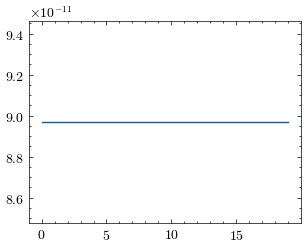

In [56]:
Q = params["env_params"]["Q"]  # total flow
choices = list(range(params["env_params"]["destinations"])) + [
    -1
]  # possible destinations + opt-out option
num_choices = len(choices)

# dataframe drivers and results
df = pd.DataFrame(index=range(Q))
df["I"] = np.random.normal(0, 10e-9, size=len(df))  # start with infidesimal noise for I


def day(df, d, params):
    # singe day

    df["choice"] = np.random.choice(choices, size=len(df))  # make random choices
    df["t"] = 0

    # to do check if newcomers equalize as well
    if d < params["env_params"]["fresh_after"]:
        df["choice"] = df.apply(
            lambda x: (
                x["choice"] if x.name > params["env_params"]["fresh_share"] else 0
            ),
            axis=1,
        )

    # for two environments
    # print("#DEBUG: number of agents", len(df))
    for i, env in enumerate(envs):
        # print(f"--- ENV {i+1} ---")
        k = len(env.routes)

        df["this_env"] = df.apply(lambda x: 1 if x.choice == i else 0, axis=1)
        df.loc[df["this_env"] == 1, "I_rank"] = df.loc[df["this_env"] == 1, "I"].rank(ascending=False).astype(int)  # prioritize higher I
        Q_env = len(df[df["this_env"] == 1])  # flow via env
        q_env = (
            params["env_params"]["congestion"] * Q_env / (Q / num_choices)
        )  # normalized for BPRs
        X, _ = findUE(q_env, env.routes)  # solve UE
        tUE = env.routes[0](X[0])  # UE time
        X, T = findSO(q_env, env.routes)  # SO flows and total travel time
        hat_T = T/ q_env  # predicted SO time per unit of flow
        tSO = [env.routes[j](X[j]) for j in range(k)]  # calc SO travel times on routes
        avg_inequity = sum([tSO[j]*X[j] for j in range(k)])/q_env - hat_T
        PoA = tUE / hat_T
        # calc realization of travel time (normal for imperfect prediction, 1e-5 for disruptions)
        p_disruption = params["env_params"]["p_disruption"]
        real_tSO = (
            tSO
            * np.random.normal(1, params["env_params"]["noise"], size=k)
            * np.random.choice([1, 10], p=[1 - p_disruption, p_disruption], size=k)
        )
        
        Inequities = [
            ((real_tSO[j] - hat_T) / hat_T) for j in range(k)
        ]  # calc inequity components

        # 1. Sort routes from fastest to slowest
        route_order = np.array(tSO).argsort()
        
        flow_sum = X.sum()
        exact_count = (X[route_order] / flow_sum) * Q_env 
        counts = np.ceil(exact_count).astype(int)
            
        splits = np.cumsum(counts)

        ranks = df.loc[df["this_env"] == 1, "I_rank"].values - 1
        assigned_bins = np.searchsorted(splits, ranks, side='right')
        assigned_bins = np.clip(assigned_bins, 0, k-1)
        
        df.loc[df["this_env"] == 1, "route"] = route_order[assigned_bins]

        inequity_map = {route_idx: Inequities[route_idx] for route_idx in range(k)}
        df.loc[df["this_env"] == 1, "inequity today"] = df.loc[df["this_env"] == 1, "route"].map(inequity_map)
        print(
            ", ".join([f"[ENV {i+1}]",
            f"PoA={PoA:.3f}",
            f"routes={k}",
            f"Q_env={Q_env:.0f}",
            f"Inequities={np.mean(Inequities):.2f}",
            f"q_env={q_env:.3f}",
            f"tUE={tUE:.3f}",
            f"mean_SO_time={np.mean(tSO):.3f}",
            f"mean_inequity={df.loc[df['this_env'] == 1, 'inequity today'].mean():.3f}",
            f"avg_inequity={avg_inequity:.3f}",
            f"tSO={tSO}"])
        )
    return df


l = list()
for d in range(20):
    df = day(df, d, params)
    l.append(df["I"].mean())
plt.plot(l)